In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import pickle
import plotly.graph_objects as go

from utils.util import read_yaml
from box import Box

import optuna
from sklearn.metrics import mean_squared_error
from math import sqrt

from utils.eda_tools import select_good_period, single_column_vis
import warnings
warnings.filterwarnings('ignore')

## V2: add time lag column

### Load Data

In [5]:
cfg = Box(read_yaml('../src/conf/config.yaml'))
Config = Box(read_yaml('../src/conf/baseline.yaml'))

In [39]:
df_path = cfg.path.processed_data
df = pd.read_csv(df_path, parse_dates=['Date'], index_col=0)

In [7]:
df.shape

(26032, 59)

In [8]:
tag_list = list(df.columns)[5:-1]
len(tag_list)

53

In [9]:
# Create a dictionary to map the category to each tag
tag_df = pd.read_excel(cfg.path.tags_info)
# delete the first 3 str characters in the tag name
tag_df['Tag'] = tag_df['Tag'].apply(lambda x: x[3:])
# convert the . into - in the tag name
tag_df['Tag'] = tag_df['Tag'].apply(lambda x: x.replace('.', '-'))

tag_dict = dict(zip(tag_df['Tag'], tag_df['Category']))
print(tag_dict)

{'OXO-5FI635C Augusta': 'Measurement', 'OXO-5FI661A Augusta': 'Measurement', 'OXO-5FI696 Augusta': 'Independent', 'OXO-5FIC132 Augusta': 'Independent', 'OXO-5FIC600 Augusta': 'Target', 'OXO-5FIC601 Augusta': 'Target', 'OXO-5FIC602 Augusta': 'Control', 'OXO-5FIC603 Augusta': 'Control', 'OXO-5FIC606A Augusta': 'Control', 'OXO-5FIC606C Augusta': 'Control', 'OXO-5FIC607 Augusta': 'Control', 'OXO-5FIC609A Augusta': 'Target', 'OXO-5FIC609B Augusta': 'Control', 'OXO-5FIC611A Augusta': 'Control', 'OXO-5FIC611B Augusta': 'Control', 'OXO-5FIC612A Augusta': 'Target', 'OXO-5FIC612B Augusta': 'Target', 'OXO-5FIC618A Augusta': 'Control', 'OXO-5FIC618B Augusta': 'Control', 'OXO-5FIC618C Augusta': 'Control', 'OXO-5FIC618D Augusta': 'Control', 'OXO-5FIC622A Augusta': 'Control', 'OXO-5FIC622B Augusta': 'Control', 'OXO-5FIC622C Augusta': 'Control', 'OXO-5FIC636A Augusta': 'Control', 'OXO-5FIC636B Augusta': 'Control', 'OXO-5FIC636C Augusta': 'Control', 'OXO-5FQI691B Augusta': 'Measurement', 'OXO-5LI633B A

In [10]:
# find tag in tag_list which has Control value in tag_dict
ctrl_tag = [tag for tag in tag_list if tag_dict[tag] == 'Control']
print(len(ctrl_tag))
# the rest of the tags are independent tags
ind_tag = [tag for tag in tag_list if tag_dict[tag] != 'Control']
len(ind_tag)

29


24

### Split Live Data

In [23]:
# df = df.iloc[:, 5:-1]

In [24]:
df.shape

(26032, 59)

In [40]:
# split and the keep the last 10% as live data
df, live_df = train_test_split(df, test_size=0.1, shuffle=False)
df.shape, live_df.shape

((23428, 59), (2604, 59))

### Trained on Shuffled Data

In [89]:
X = df[ctrl_tag+ind_tag]
y = df[cfg.kpi1.tag1]

# add a time lag column of y to X
X['y_lag'] = y.shift(1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)
# split the data into train, validation and test set by 8:1:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [60]:
X_train.shape, X_test.shape, X_val.shape

((18742, 54), (2343, 54), (2343, 54))

In [29]:
# Define the objective function to be optimized
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, step=1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50),
    }

    # Create and train the XGBRegressor with the specified hyperparameters
    model = XGBRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_val)
    rmse = sqrt(mean_squared_error(y_val, y_pred))

    return rmse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-07-21 15:40:01,198] A new study created in memory with name: no-name-cb5911e2-896b-4c65-85ac-6b171f5b5c83
[I 2023-07-21 15:40:31,196] Trial 0 finished with value: 300.67786106048163 and parameters: {'n_estimators': 8000, 'max_depth': 3, 'learning_rate': 0.08188743908965083, 'subsample': 0.9892736904677315, 'colsample_bytree': 0.2980041802053259, 'min_child_weight': 10, 'reg_alpha': 0.29986521245825104, 'reg_lambda': 0.24812722689423738, 'early_stopping_rounds': 39}. Best is trial 0 with value: 300.67786106048163.
[I 2023-07-21 15:49:32,531] Trial 1 finished with value: 284.5397042128458 and parameters: {'n_estimators': 10000, 'max_depth': 8, 'learning_rate': 0.0019633843174846023, 'subsample': 0.9294503796348454, 'colsample_bytree': 0.3914904317475214, 'min_child_weight': 5, 'reg_alpha': 0.1136717125414779, 'reg_lambda': 0.7744710470034709, 'early_stopping_rounds': 33}. Best is trial 1 with value: 284.5397042128458.
[I 2023-07-21 15:53:01,292] Trial 2 finished with value: 288.2

In [30]:
# Get the best hyperparameters
best_params_shuffled = study.best_params
print("Best Hyperparameters:", best_params_shuffled)

Best Hyperparameters: {'n_estimators': 4000, 'max_depth': 10, 'learning_rate': 0.007561363159167393, 'subsample': 0.8131065794452833, 'colsample_bytree': 0.5664053001442664, 'min_child_weight': 9, 'reg_alpha': 0.08703941325890176, 'reg_lambda': 0.2848960362084546, 'early_stopping_rounds': 37}


In [90]:
# model_on_shuffled = XGBRegressor(**best_params_shuffled)
best_model_on_shuffled = XGBRegressor(**{'n_estimators': 4000, 'max_depth': 10, 'learning_rate': 0.007561363159167393, 'subsample': 0.8131065794452833, 'colsample_bytree': 0.5664053001442664, 'min_child_weight': 9, 'reg_alpha': 0.08703941325890176, 'reg_lambda': 0.2848960362084546, 'early_stopping_rounds': 37})

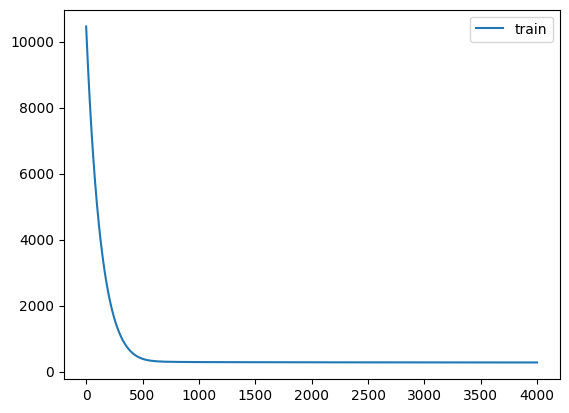

In [91]:
best_model_on_shuffled.fit(X_train, y_train, 
             eval_set=[(X_val, y_val)], verbose=False)

results = best_model_on_shuffled.evals_result()

# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
# plt.plot(results['validation_1']['rmse'], label='validation')
# show the legend
plt.legend()
# show the plot
plt.show()

In [92]:
# calculate the rmse on train and test set
from sklearn.metrics import mean_squared_error
from math import sqrt

y_train_pred = best_model_on_shuffled.predict(X_train)
y_val_pred = best_model_on_shuffled.predict(X_val)
y_test_pred = best_model_on_shuffled.predict(X_test)

rmse_train_shuffled = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val_shuffled = sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test_shuffled = sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE on train set:", rmse_train_shuffled)
print("RMSE on validation set:", rmse_val_shuffled)
print("RMSE on test set:", rmse_test_shuffled)

RMSE on train set: 86.32701622771702
RMSE on validation set: 276.6956509460567
RMSE on test set: 345.0942222693697


In [93]:
# calculate the rmse on live set
live_X = live_df[ctrl_tag+ind_tag]
live_y = live_df[cfg.kpi1.tag1]
live_X['y_lag'] = live_y.shift(1)

live_y_pred = best_model_on_shuffled.predict(live_X)
rmse_live_shuffled = sqrt(mean_squared_error(live_y, live_y_pred))
print("RMSE on live set:", rmse_live_shuffled)

RMSE on live set: 883.0533989468089


#### Visualization

In [95]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=live_X.index, y=live_y, mode='lines', name='actual'))
fig.add_trace(go.Scatter(x=live_X.index, y=live_y_pred, mode='lines', name='prediction'))
fig.update_layout(title='Prediction on Live Set for Best Model Trained on Shuffled Data Adding Lagged Feature Y',
                xaxis_title='Date',
                yaxis_title='Y Value',
                width=1200,
                height=600)
fig.write_html(cfg.shuffle_or_not.v2.shuffle.live_plot)
fig.show()

### Trained on Unshuffled Data

In [75]:
X = df[ctrl_tag+ind_tag]
y = df[cfg.kpi1.tag1]

# add a time lag column of y to X
# X['y_lag'] = y.shift(1)
# X['y_lag2'] = y.shift(2)
# X['y_lag3'] = y.shift(3)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False, random_state=42)

In [39]:
# Define the objective function to be optimized
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, step=1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50),
    }

    # Create and train the XGBRegressor with the specified hyperparameters
    model = XGBRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_val)
    rmse = sqrt(mean_squared_error(y_val, y_pred))

    return rmse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-07-24 09:36:34,062] A new study created in memory with name: no-name-e73ff3f1-6e52-493c-b7b7-577c243b221b


[I 2023-07-24 09:37:52,524] Trial 0 finished with value: 560.3536591053315 and parameters: {'n_estimators': 6000, 'max_depth': 4, 'learning_rate': 0.0027206494540326503, 'subsample': 0.9885448106589565, 'colsample_bytree': 0.5263021270743445, 'min_child_weight': 9, 'reg_alpha': 0.06588844803822258, 'reg_lambda': 0.3470006588652439, 'early_stopping_rounds': 50}. Best is trial 0 with value: 560.3536591053315.
[I 2023-07-24 09:37:54,714] Trial 1 finished with value: 585.5855433534988 and parameters: {'n_estimators': 3000, 'max_depth': 1, 'learning_rate': 0.055783768851470274, 'subsample': 0.24820278286312372, 'colsample_bytree': 0.3096032186842129, 'min_child_weight': 9, 'reg_alpha': 0.3710380597441081, 'reg_lambda': 0.07877908679952073, 'early_stopping_rounds': 29}. Best is trial 0 with value: 560.3536591053315.
[I 2023-07-24 09:39:56,552] Trial 2 finished with value: 683.0927037866998 and parameters: {'n_estimators': 3000, 'max_depth': 10, 'learning_rate': 0.005297538605771617, 'subsamp

In [ ]:
# Get the best hyperparameters
best_params_unshuffled = study.best_params
print("Best Hyperparameters:", best_params_unshuffled)

In [76]:
# best_model_on_unshuffled = XGBRegressor(**best_params_unshuffled)
best_model_on_unshuffled = XGBRegressor(**{'n_estimators': 9000, 'max_depth': 2, 'learning_rate': 0.05974183269036751, 'subsample': 0.4678621497249791, 'colsample_bytree': 0.878451077257514, 'min_child_weight': 3, 'reg_alpha': 0.7586221690145304, 'reg_lambda': 0.5213509710908082, 'early_stopping_rounds': 42})

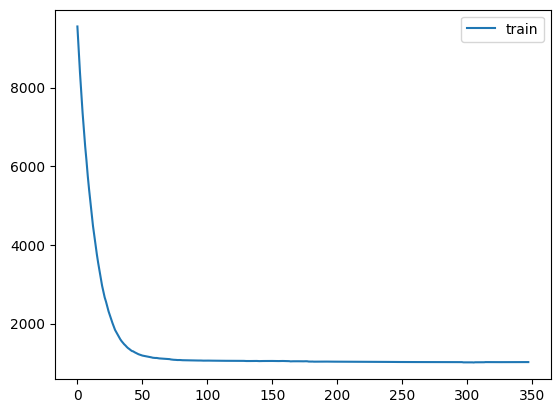

In [77]:
best_model_on_unshuffled.fit(X_train, y_train, 
             eval_set=[(X_val, y_val)], verbose=False)

results = best_model_on_unshuffled.evals_result()

# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
# plt.plot(results['validation_1']['rmse'], label='validation')
# show the legend
plt.legend()
# show the plot
plt.show()

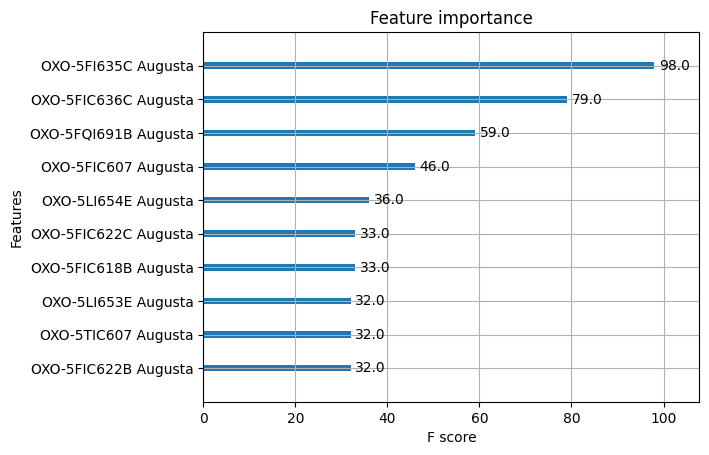

In [78]:
# feature importance
from xgboost import plot_importance
plot_importance(best_model_on_unshuffled, max_num_features=10)
plt.show()

In [61]:
y_train_pred = best_model_on_unshuffled.predict(X_train)
y_val_pred = best_model_on_unshuffled.predict(X_val)
y_test_pred = best_model_on_unshuffled.predict(X_test)

rmse_train_unshuffled = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val_unshuffled = sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test_unshuffled = sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE on train set:", rmse_train_unshuffled)
print("RMSE on validation set:", rmse_val_unshuffled)
print("RMSE on test set:", rmse_test_unshuffled)

RMSE on train set: 561.0302686180951
RMSE on validation set: 677.8235097898008
RMSE on test set: 628.6328762686489


In [79]:
# calculate the rmse on live set
live_X = live_df[ctrl_tag+ind_tag]
live_y = live_df[cfg.kpi1.tag1]
# live_X['y_lag'] = live_y.shift(1)
# live_X['y_lag2'] = live_y.shift(2)
# live_X['y_lag3'] = live_y.shift(3)


live_y_pred = best_model_on_unshuffled.predict(live_X)
rmse_live_unshuffled = sqrt(mean_squared_error(live_y, live_y_pred))
print("RMSE on live set:", rmse_live_unshuffled)

RMSE on live set: 1392.6659749922962


#### Visualization

In [70]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_train.index, y=y_train, mode='lines', name='actual'))
fig.add_trace(go.Scatter(x=X_train.index, y=y_train_pred, mode='lines', name='prediction'))
fig.update_layout(title='Prediction on Train Set for Best Model Trained on Unshuffled Data Adding Lagged Feature Y',
                xaxis_title='Date',
                yaxis_title='Y Value',
                width=1200,
                height=600)
fig.write_html(cfg.shuffle_or_not.v2.unshuffle.train_plot)
fig.show()

In [71]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_val.index, y=y_val, mode='lines', name='actual'))
fig.add_trace(go.Scatter(x=X_val.index, y=y_val_pred, mode='lines', name='prediction'))
fig.update_layout(title='Prediction on Validation Set for Best Model Trained on Unshuffled Data Adding Lagged Feature Y',
                xaxis_title='Date',
                yaxis_title='Y Value',
                width=1200,
                height=600)
fig.write_html(cfg.shuffle_or_not.v2.unshuffle.val_plot)
fig.show()

In [72]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='actual'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_test_pred, mode='lines', name='prediction'))
fig.update_layout(title='Prediction on Test Set for Best Model Trained on Unshuffled Data Adding Lagged Feature Y',
                xaxis_title='Date',
                yaxis_title='Y Value',
                width=1200,
                height=600)
# fig.write_html(cfg.shuffle_or_not.v2.unshuffle.test_plot)
fig.show()

In [80]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=live_X.index, y=live_y, mode='lines', name='actual'))
fig.add_trace(go.Scatter(x=live_X.index, y=live_y_pred, mode='lines', name='prediction'))
fig.update_layout(title='Prediction on Live Set for Best Model Trained on Unshuffled Data Adding Lagged Feature Y',
                xaxis_title='Date',
                yaxis_title='Y Value',
                width=1200,
                height=600)
# fig.write_html(cfg.shuffle_or_not.v2.unshuffle.live_plot)
fig.show()

In [81]:
# truncate the live set from Jan 28 to Feb 3
live_X_sample = live_X.loc['2023-01-28':'2023-02-03']
live_y_sample = live_y.loc['2023-01-28':'2023-02-03']
# get the prediction on the live set from Jan 28 to Feb 3
live_y_pred_sample = best_model_on_unshuffled.predict(live_X_sample)

fig = go.Figure()
fig.add_trace(go.Scatter(x=live_X_sample.index, y=live_y_sample, mode='lines', name='actual'))
fig.add_trace(go.Scatter(x=live_X_sample.index, y=live_y_pred_sample, mode='lines', name='prediction'))
fig.update_layout(title='Prediction on Live Set for Best Model Trained on Unshuffled Data Adding Lagged Feature Y',
                xaxis_title='Date',
                yaxis_title='Y Value',
                width=1200,
                height=600)
fig.show()

### Summary

In [106]:
# make a table to compare the results

# create a dataframe to store the results
results_df = pd.DataFrame(columns=['RMSE on Train Set', 'RMSE on Validation Set', 'RMSE on Test Set', 'RMSE on Live Set'], index=['Shuffled Data', 'Unshuffled Data'])
results_df.loc['Shuffled Data', 'RMSE on Train Set'] = rmse_train_shuffled
results_df.loc['Shuffled Data', 'RMSE on Validation Set'] = rmse_val_shuffled
results_df.loc['Shuffled Data', 'RMSE on Test Set'] = rmse_test_shuffled
results_df.loc['Shuffled Data', 'RMSE on Live Set'] = rmse_live_shuffled

results_df.loc['Unshuffled Data', 'RMSE on Train Set'] = rmse_train_unshuffled
results_df.loc['Unshuffled Data', 'RMSE on Validation Set'] = rmse_val_unshuffled
results_df.loc['Unshuffled Data', 'RMSE on Test Set'] = rmse_test_unshuffled
results_df.loc['Unshuffled Data', 'RMSE on Live Set'] = rmse_live_unshuffled

results_df

,RMSE on Train Set,RMSE on Validation Set,RMSE on Test Set,RMSE on Live Set
Shuffled Data,86.327016,276.695651,345.094222,883.053399
Unshuffled Data,380.685014,438.432115,473.887532,495.219395


In [118]:
# using plotly to visualize the table
fig = go.Figure(data=[go.Table(
    header=dict(values=list(results_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[results_df['RMSE on Train Set'], results_df['RMSE on Validation Set'], results_df['RMSE on Test Set'], results_df['RMSE on Live Set']],
                fill_color='lavender',
                align='left'))
])

fig.update_layout(title='Comparison of RMSE on Different Datasets for Best Model Trained on Shuffled and Unshuffled Data Adding Lagged Feature Y',
                width=1200,
                height=600)
# save fig as html
fig.write_html(cfg.shuffle_or_not.v2.table)
fig.show()